In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

"""
  Wyrysowuje filter nałożony na obrazy
"""
def plot_filter(images, filter):
  images = images = torch.cat([i.unsqueeze(0) for i in images], dim=0).cpu()
  filter = torch.FloatTensor(filter).unsqueeze(0).unsqueeze(0).cpu()
  n_images = images.shape[0]
  filtered_images = F.conv2d(images, filter)
  fig = plt.figure(figsize=(20, 5))
  for i in range(n_images):
    ax = fig.add_subplot(2, n_images, i + 1)
    ax.imshow(images[i].squeeze(0), cmap='bone')
    ax.set_title('Original')
    ax.axis('off')
    image = filtered_images[i].squeeze(0)
    ax = fig.add_subplot(2, n_images, n_images + i + 1)
    ax.imshow(image, cmap='bone')
    ax.set_title(f'Filtered')
    ax.axis('off')
  fig.show()

"""
  Model LeNet:
  - opisać użyte funkcje oraz dodać komentarze nad każdą linijką
"""
class LeNet(nn.Module):
  # Uruchomienie metody inicjalizującej(konstruktora), wykonującej się przy powstaniu obiektu
  def __init__(self, output_dim, input_dim, inp, out):
    # Uruchomienie konstruktora __init__() obiektu narzędnego tzn. nn.Module po, którym dziedziczy LeNet
    super().__init__()
    # Konwolucja map cech obiektu wejściowego z filtrem
    # in_channels - Liczba kanałów w obrazie wejściowym
    # out_channels - Liczba kanałów wyprodukowanych przez konwolucję
    # kernel_size - Rozmiar filtra konwolucji, określa długość i wysokość maski filtra
    self.conv1 = nn.Conv2d(in_channels=1,
                           out_channels=6,
                           kernel_size=5)
     # Druga konwolucja map cech obiektu wejściowego (tzn. wyjściowego z conv1) z filtrem
    self.conv2 = nn.Conv2d(in_channels=6,
                           out_channels=16,
                           kernel_size=5)
    # nn.Linear(x_size, y_size) jest funkcją realizującą transformację liniową do przychodzących danych: 
    # y = x * W ^ T + b. W parametrach przyjmuje wielkości każdej próbki wejścia i wyjścia czyli w tym
    # przypadku ilość neuronów na warstwie.
    # Są trzy warstwy (fc - fully connected - traktuje wejście jako jednowymiarową listę)
    # Do pierwszej warstwy przekazywane są 256 cechy wejściowe,120 to liczba cech wyjściowych 
    self.fc_1 = nn.Linear(input_dim, inp)
    # Do drugiej warstwy przekazywane są 120 cechy wejściowe (cechy wyjściowe fc_1),84 to liczba cech 
    # wyjściowych
    self.fc_2 = nn.Linear(inp, out)
    # W trzeciej warstwie 84 cechy wejściowe, output_dim to liczba zdefiniowanych klas wyjściowych (10)
    self.fc_3 = nn.Linear(out, output_dim)
  # Propagacja do przodu.Definiuje obliczneia, operacje, funkcje, któ©e mają sie  wykonać
  # przy każdym wywołaniu. 
  def forward(self, x):
    # Pierwsza konwolucja na warstwie wejściowej
    x = self.conv1(x)
    # Pooling po oknie 2x2. Przechodzenie po fragmencie i wybraniu wartości maksymalnej.
    x = F.max_pool2d(x, kernel_size=2)
    # Zastosowanie na tę warstwę funkcji aktywacji ReLu
    x = F.relu(x)
    # Druga konwolucja (konwolucje i transformacje zdefiniowane w __init__() - tu ich wywołanie)
    x = self.conv2(x)
    # Ponowny pooling po oknie 2x2. Przechodzenie po fragmencie i wybraniu wartości maksymalnej.
    x = F.max_pool2d(x, kernel_size=2)
    # Zastosowanie na tę warstwę funkcji aktywacji ReLu
    x = F.relu(x)
    # Zmiana kształtu tensora aby otrzymać płaski w pełni połączoną warstwę. Gdy chcemy aby w x była konkretna 
    # liczba (x.shape[0]) wierszy, ale nie jesteśmy pewni ilości kolumn można wpisać -1. Dzięki temu tensor 
    # wyliczy odpowiednią liczbę kolumn dla zadanej liczby wierszy.
    x = x.view(x.shape[0], -1)
    h = x
    # Wyliczenie pierwszej w pełni połączonej warstwy
    x = self.fc_1(x)
    # Zastosowanie na tę warstwę funkcji aktywacji ReLu
    x = F.relu(x)
    # Wyliczenie drugiej w pełni połączonej warstwy
    x = self.fc_2(x)
    # Zastosowanie na tę warstwę funkcji aktywacji ReLu
    x = F.relu(x)
    # Zastosowanie na tę warstwę funkcji aktywacji ReLu
    x = self.fc_3(x)
    # Zwrócenie warstwy po zaaplikowaniu na niej powyższych komputacji
    return x, h


def calculate_accuracy(y_pred, y):
  top_pred = y_pred.argmax(1, keepdim=True)
  correct = top_pred.eq(y.view_as(top_pred)).sum()
  acc = correct.float() / y.shape[0]
  return acc


def train(model, iterator, optimizer, criterion, device):
  epoch_loss = 0
  epoch_acc = 0

  model.train()

  for (x, y) in iterator:
    x = x.to(device)
    y = y.to(device)
    optimizer.zero_grad()
    y_pred, _ = model(x)
    loss = criterion(y_pred, y)
    acc = calculate_accuracy(y_pred, y)
    loss.backward()
    optimizer.step()
    epoch_loss += loss.item()
    epoch_acc += acc.item()

  return epoch_loss / len(iterator), epoch_acc / len(iterator)


def evaluate(model, iterator, criterion, device):
  epoch_loss = 0
  epoch_acc = 0

  model.eval()

  with torch.no_grad():
    for (x, y) in iterator:
      x = x.to(device)
      y = y.to(device)
      y_pred, _ = model(x)
      loss = criterion(y_pred, y)
      acc = calculate_accuracy(y_pred, y)
      epoch_loss += loss.item()
      epoch_acc += acc.item()

  return epoch_loss / len(iterator), epoch_acc / len(iterator)


def epoch_time(start_time, end_time):
  elapsed_time = end_time - start_time
  elapsed_mins = int(elapsed_time / 60)
  elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
  return elapsed_mins, elapsed_secs


def get_predictions(model, iterator, device):
  model.eval()
  images = []
  labels = []
  probs = []

  with torch.no_grad():
    for (x, y) in iterator:
      x = x.to(device)
      y_pred, _ = model(x)
      y_prob = F.softmax(y_pred, dim=-1)
      top_pred = y_prob.argmax(1, keepdim=True)
      images.append(x.cpu())
      labels.append(y.cpu())
      probs.append(y_prob.cpu())

  images = torch.cat(images, dim=0)
  labels = torch.cat(labels, dim=0)
  probs = torch.cat(probs, dim=0)

  return images, labels, probs


def plot_confusion_matrix(labels, pred_labels):
  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot(1, 1, 1)
  cm = confusion_matrix(labels, pred_labels)
  cm = ConfusionMatrixDisplay(cm, range(10))
  cm.plot(values_format='d', cmap='Blues', ax=ax)
  fig.show()


def plot_most_incorrect(incorrect, n_images):
  rows = int(np.sqrt(n_images))
  cols = int(np.sqrt(n_images))
  fig = plt.figure(figsize=(20, 10))
  for i in range(rows * cols):
    ax = fig.add_subplot(rows, cols, i + 1)
    image, true_label, probs = incorrect[i]
    true_prob = probs[true_label]
    incorrect_prob, incorrect_label = torch.max(probs, dim=0)
    ax.imshow(image.view(28, 28).cpu().numpy(), cmap='bone')
    ax.set_title(f'true label: {true_label} ({true_prob:.3f})\n' \
                 f'pred label: {incorrect_label} ({incorrect_prob:.3f})')
    ax.axis('off')
  fig.subplots_adjust(hspace=0.5)
  fig.show()


def plot_subsample(images, pool_type, pool_size):
  images = torch.cat([i.unsqueeze(0) for i in images], dim=0).cpu()
  if pool_type.lower() == 'max':
    pool = F.max_pool2d
  elif pool_type.lower() in ['mean', 'avg']:
    pool = F.avg_pool2d
  else:
    raise ValueError(f'pool_type must be either max or mean, got: {pool_type}')

  n_images = images.shape[0]
  pooled_images = pool(images, kernel_size=pool_size)
  fig = plt.figure(figsize=(20, 5))
  for i in range(n_images):
    ax = fig.add_subplot(2, n_images, i + 1)
    ax.imshow(images[i].squeeze(0), cmap='bone')
    ax.set_title('Original')
    ax.axis('off')
    image = pooled_images[i].squeeze(0)
    ax = fig.add_subplot(2, n_images, n_images + i + 1)
    ax.imshow(image, cmap='bone')
    ax.set_title(f'Subsampled')
    ax.axis('off');


/home/rhag/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


The model has 258,832 trainable parameters
Epoch: 01 | Epoch Time: 0m 22s
	Train Loss: 0.326 | Train Acc: 89.65%
	 Val. Loss: 0.119 |  Val. Acc: 96.32%
Epoch: 02 | Epoch Time: 0m 25s
	Train Loss: 0.104 | Train Acc: 96.75%
	 Val. Loss: 0.071 |  Val. Acc: 97.98%
Epoch: 03 | Epoch Time: 0m 25s
	Train Loss: 0.080 | Train Acc: 97.47%
	 Val. Loss: 0.055 |  Val. Acc: 98.27%
Epoch: 04 | Epoch Time: 0m 26s
	Train Loss: 0.069 | Train Acc: 97.83%
	 Val. Loss: 0.058 |  Val. Acc: 98.28%
Epoch: 05 | Epoch Time: 0m 26s
	Train Loss: 0.058 | Train Acc: 98.18%
	 Val. Loss: 0.047 |  Val. Acc: 98.68%
Epoch: 06 | Epoch Time: 0m 26s
	Train Loss: 0.053 | Train Acc: 98.27%
	 Val. Loss: 0.050 |  Val. Acc: 98.61%
Epoch: 07 | Epoch Time: 0m 27s
	Train Loss: 0.050 | Train Acc: 98.43%
	 Val. Loss: 0.047 |  Val. Acc: 98.58%
Epoch: 08 | Epoch Time: 0m 27s
	Train Loss: 0.047 | Train Acc: 98.54%
	 Val. Loss: 0.048 |  Val. Acc: 98.70%
Epoch: 09 | Epoch Time: 0m 27s
	Train Loss: 0.045 | Train Acc: 98.58%
	 Val. Loss: 0.

/home/rhag/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:182: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/home/rhag/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:199: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


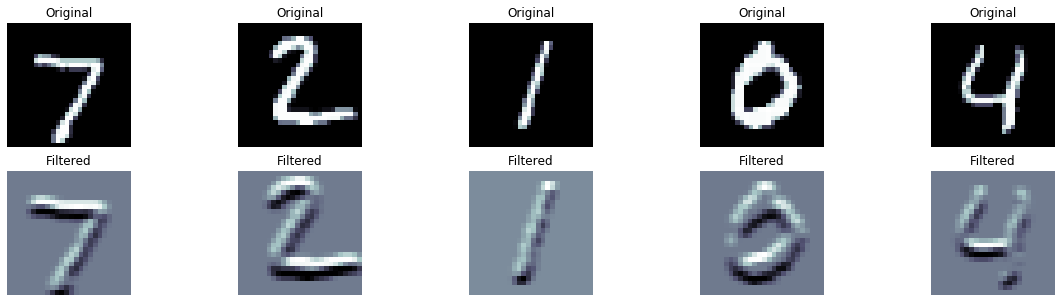

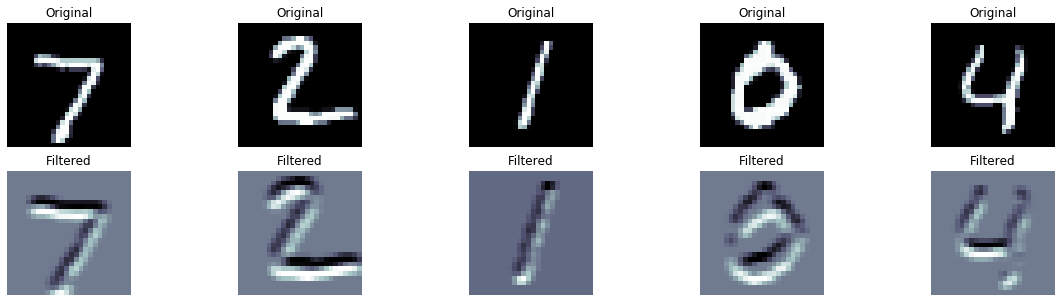

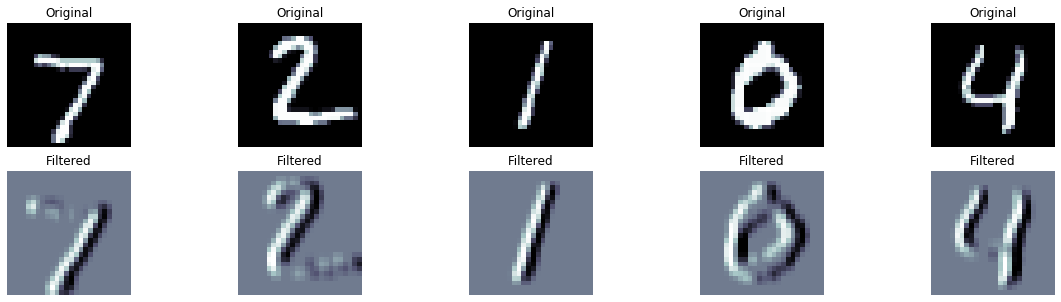

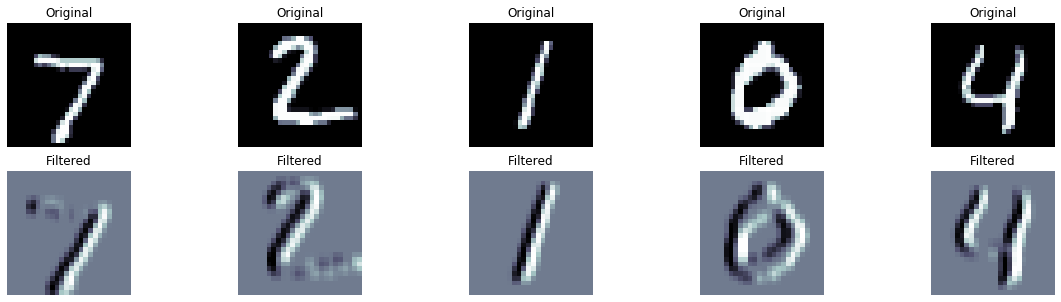

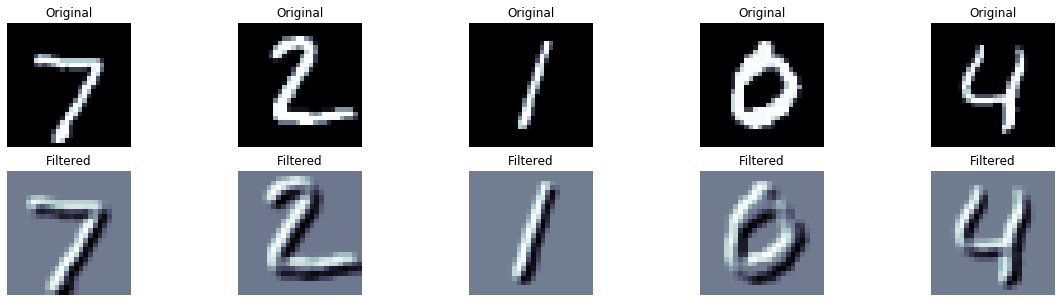

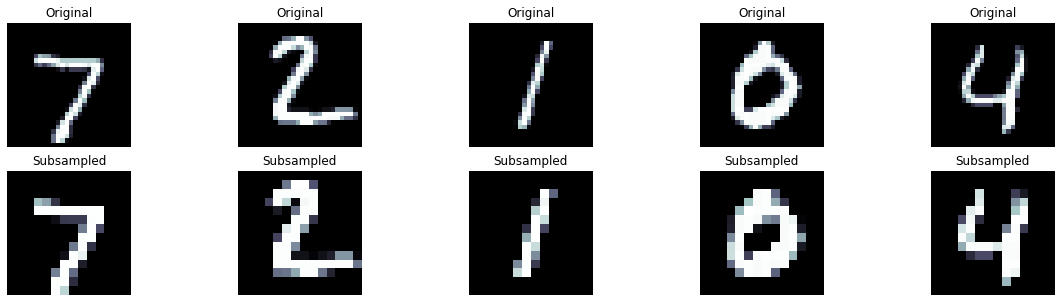

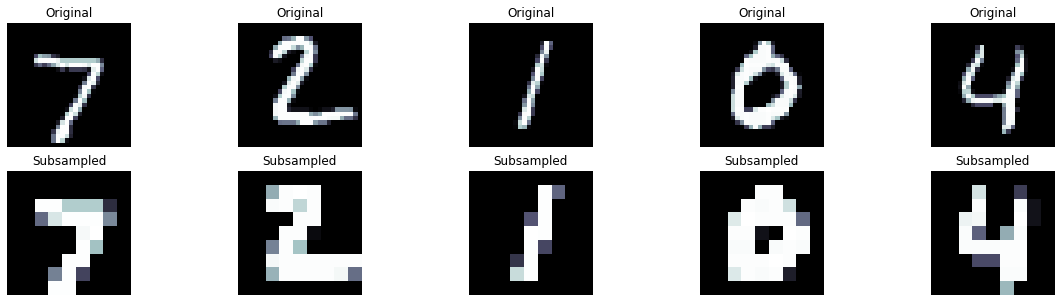

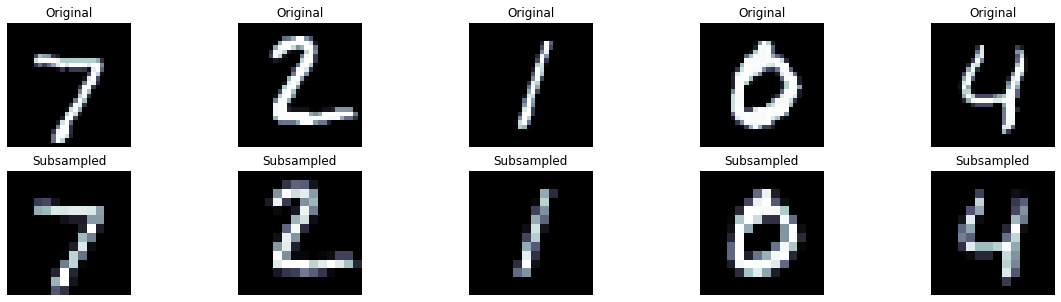

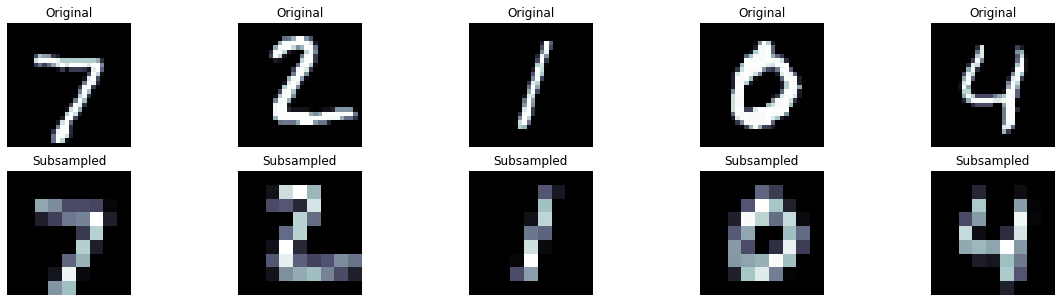

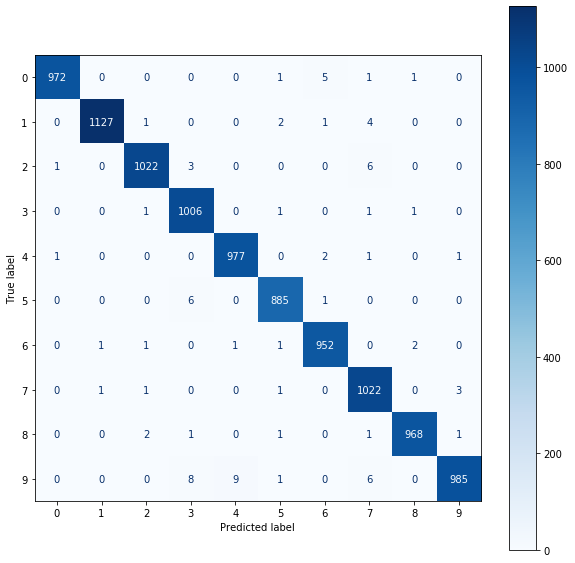

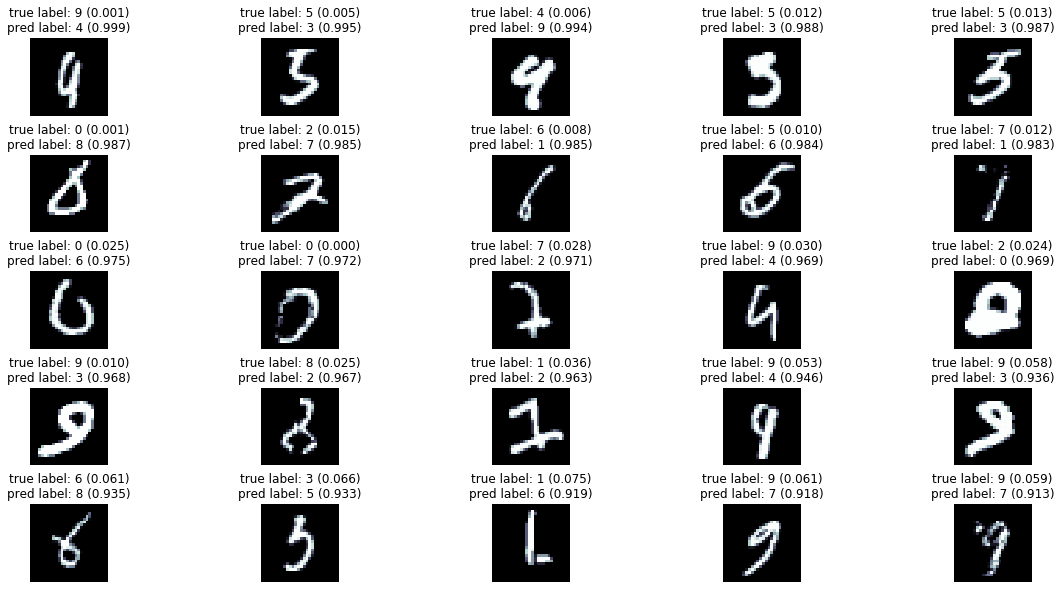

In [4]:
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import copy
import random
import time


SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

ROOT = 'data'

# Standaryzacja danych
train_data = datasets.MNIST(root=ROOT,
                            train=True,
                            download=True)

mean = train_data.data.float().mean() / 255
std = train_data.data.float().std() / 255

#print(f'Calculated mean: {mean}')
#print(f'Calculated std: {std}')

# Definicja transformacji zbioru testowego oraz treningowego
train_transforms = transforms.Compose([
  transforms.RandomRotation(5, fill=(0,)),
  transforms.RandomCrop(28, padding=2),
  transforms.ToTensor(),
  transforms.Normalize(mean=[mean], std=[std])
])

test_transforms = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize(mean=[mean], std=[std])
])

train_data = datasets.MNIST(root=ROOT,
                            train=True,
                            download=True,
                            transform=train_transforms)

test_data = datasets.MNIST(root=ROOT,
                           train=False,
                           download=True,
                           transform=test_transforms)

# Tworzenie zbioru walidacyjnego
VALID_RATIO = 0.9
n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples
train_data, valid_data = data.random_split(train_data,
                                           [n_train_examples, n_valid_examples])
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms
#print(f'Number of training examples: {len(train_data)}')
#print(f'Number of validation examples: {len(valid_data)}')
#print(f'Number of testing examples: {len(test_data)}')

BATCH_SIZE = 64

train_iterator = data.DataLoader(train_data,
                                 shuffle=True,
                                 batch_size=BATCH_SIZE)

valid_iterator = data.DataLoader(valid_data,
                                 batch_size=BATCH_SIZE)

test_iterator = data.DataLoader(test_data,
                                batch_size=BATCH_SIZE)

N_IMAGES = 5

images = [image for image, label in [test_data[i] for i in range(N_IMAGES)]]

horizontal_filter = [[-1, -2, -1],
                     [0, 0, 0],
                     [1, 2, 1]]
plot_filter(images, horizontal_filter)

horizontal_filter = [[1, 2, 1],
                     [0, 0, 0],
                     [-1, -2, -1]]
plot_filter(images, horizontal_filter)

vertical_filter = [[-1, 0, 1],
                   [-2, 0, 2],
                   [-1, 0, 1]]
plot_filter(images, vertical_filter)

vertical_filter = [[1, 0, -1],
                   [2, 0, -2],
                   [1, 0, -1]]
plot_filter(images, vertical_filter)

diagonal_filter = [[-2, -1, 0],
                   [-1, 0, 1],
                   [0, 1, 2]]
plot_filter(images, diagonal_filter)


plot_subsample(images, 'max', 2)

plot_subsample(images, 'max', 3)

plot_subsample(images, 'avg', 2)

plot_subsample(images, 'avg', 3)

OUTPUT_DIM = 10
##########
model = LeNet(OUTPUT_DIM, 256, 500,250)
#########
    


def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f'The model has {count_parameters(model):,} trainable parameters')


# Trenowanie modelu

optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = criterion.to(device)

EPOCHS = 20

best_valid_loss = float('inf')

for epoch in range(EPOCHS):

  start_time = time.time()

  train_loss, train_acc = train(model, train_iterator, optimizer, criterion,
                                device)
  valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)

  if valid_loss < best_valid_loss:
    best_valid_loss = valid_loss
    torch.save(model.state_dict(), 'cnn-model.pt')

  end_time = time.time()

  epoch_mins, epoch_secs = epoch_time(start_time, end_time)

  print(f'Epoch: {epoch + 1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
  print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc * 100:.2f}%')
  print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc * 100:.2f}%')

model.load_state_dict(torch.load('cnn-model.pt'))
test_loss, test_acc = evaluate(model, test_iterator, criterion, device)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc * 100:.2f}%')

# Weryfikacja modelu

images, labels, probs = get_predictions(model, test_iterator, device)
pred_labels = torch.argmax(probs, 1)
plot_confusion_matrix(labels, pred_labels)

corrects = torch.eq(labels, pred_labels)

incorrect_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):
  if not correct:
    incorrect_examples.append((image, label, prob))

incorrect_examples.sort(reverse=True,
                        key=lambda x: torch.max(x[2], dim=0).values)

N_IMAGES = 25

plot_most_incorrect(incorrect_examples, N_IMAGES)
